## For a perturbation, check how many lambda windows we need per step by using varying numbers of lambda simulations.

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import numpy as np
from math import sqrt

from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG=True
from IPython.display import display
from PIL import Image

import matplotlib.image as mpimg 
import seaborn as sns
from matplotlib import colors

In [2]:
def plotOverlapMatrix(info, ax, title, colourbar=False):
    ovlp_mtx = np.matrix(info)
    ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))


    cmap = colors.ListedColormap(['#FBE8EB','#88CCEE','#78C592', '#117733'])
    bounds=[0.0, 0.025, 0.1, 0.3,0.8]
    norm = colors.BoundaryNorm(bounds, cmap.N, clip=False)
    cbar_kws=dict(ticks=[.025, .1, .3,0.8])
    if colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3, 
                    annot_kws={"size": 12},square=False,robust=True,cmap=cmap, 
                    norm=norm,cbar_kws=cbar_kws, ax=ax)
    elif not colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3,cmap=cmap, 
                    annot_kws={"size": 12},square=False,robust=True, 
                    norm=norm, ax=ax, cbar=False)
    ax.set_title(title)
    ax.xaxis.tick_top()

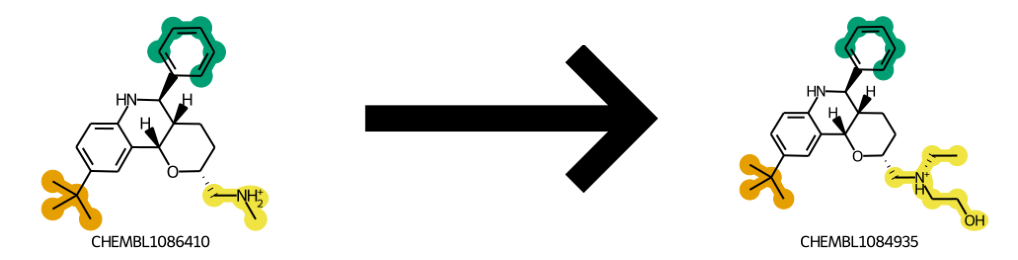

In [27]:
ligA = "CHEMBL1086410"
ligB = "CHEMBL1084935"

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

f, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].imshow(imgA)
ax[1].imshow(arrow)

# turn off axes for perturbation:
for axis in ax:
    axis.axis('off')

ax[2].imshow(imgB)
plt.show()

## Vanilla

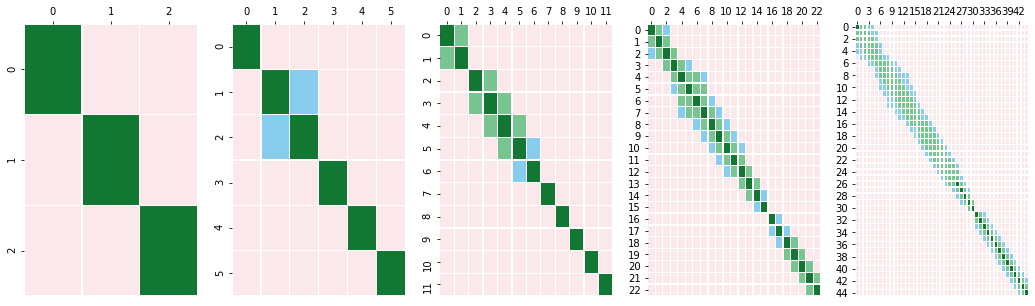

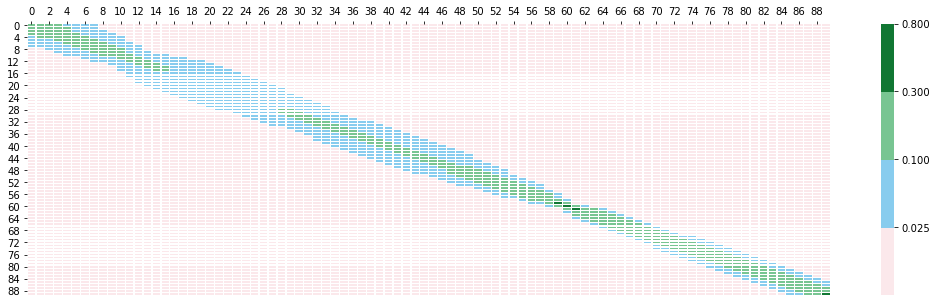

In [23]:
matrix_files = glob.glob("../yOUTPUTS/lambda_subselector/vanilla/*.m")
matrices = []
for m_file in matrix_files:
    M = np.loadtxt(m_file)
    num_lam = len(M)
    matrices.append([M, num_lam])
matrices.sort(key=lambda x: int(x[1]))

f, axes = plt.subplots(1, len(matrices)-1, figsize=(18,5))

for M, ax in zip(matrices, axes):
    num_lambdas = M[1]
    plotOverlapMatrix(M[0], ax, "")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(18,5))
num_lambdas = matrices[-1][1]
plotOverlapMatrix(matrices[-1][0], ax, "", colourbar=True)
plt.show()

## 3_flip

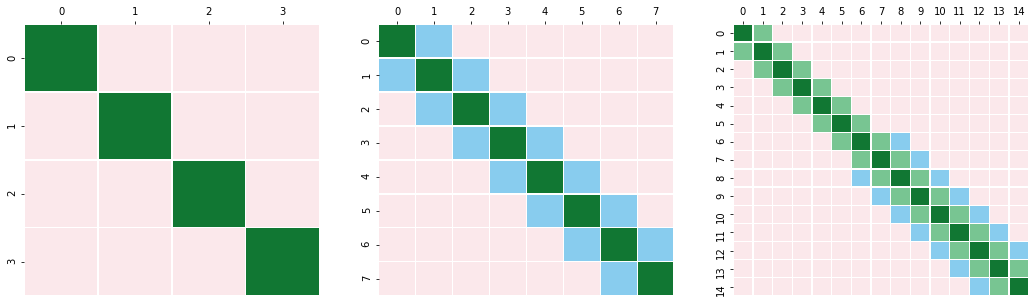

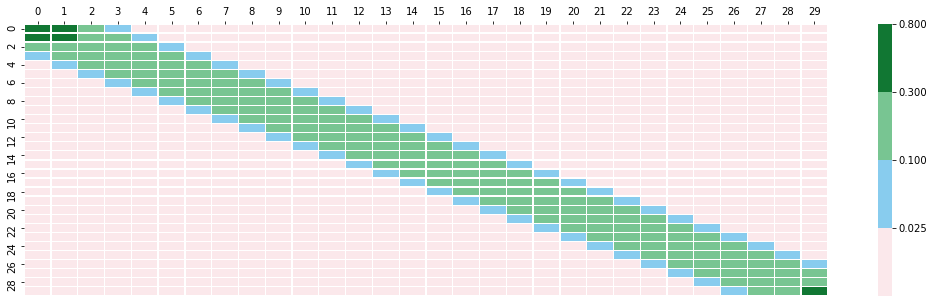

In [24]:
matrix_files = glob.glob("../yOUTPUTS/lambda_subselector/3_flip/*.m")
matrices = []
for m_file in matrix_files:
    M = np.loadtxt(m_file)
    num_lam = len(M)
    matrices.append([M, num_lam])
matrices.sort(key=lambda x: int(x[1]))

f, axes = plt.subplots(1, len(matrices)-1, figsize=(18,5))

for M, ax in zip(matrices, axes):
    num_lambdas = M[1]
    plotOverlapMatrix(M[0], ax, "")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(18,5))
num_lambdas = matrices[-1][1]
plotOverlapMatrix(matrices[-1][0], ax, "", colourbar=True)
plt.show()

## 4_grow_soft

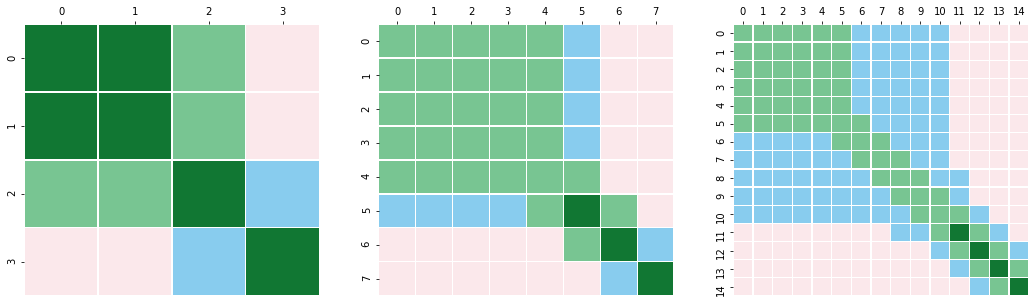

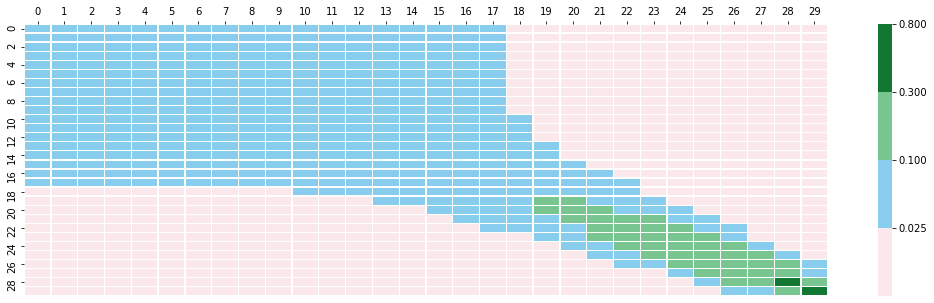

In [25]:
matrix_files = glob.glob("../yOUTPUTS/lambda_subselector/4_grow_soft/*.m")
matrices = []
for m_file in matrix_files:
    M = np.loadtxt(m_file)
    num_lam = len(M)
    matrices.append([M, num_lam])
matrices.sort(key=lambda x: int(x[1]))

f, axes = plt.subplots(1, len(matrices)-1, figsize=(18,5))

for M, ax in zip(matrices, axes):
    num_lambdas = M[1]
    plotOverlapMatrix(M[0], ax, "")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(18,5))
num_lambdas = matrices[-1][1]
plotOverlapMatrix(matrices[-1][0], ax, "", colourbar=True)
plt.show()

## Re-run with more lambdas and larger perts

In [222]:
def grabMBARFreenrg(mbar_out_path):
    """Reads an MBAR outfile and returns the MBAR computed free energy and the number of lambda windows"""
    
    freenrg = 0
    num_lambdas = None
    
    with open(mbar_out_path, "r") as readfile:
        reader = csv.reader(readfile)
        for row in reader:

            if row:
                # derive number of lambdas from header:
                if "# Analysing data contained in" in row[0]:
                    num_lambdas = len(row)      

                # get the freenrg:
                if "#MBAR free energy" in row[0]:
                    prediction_line = next(readfile)
                    freenrg = (prediction_line.split(",")[0])
#         if not freenrg:
#             #raise Exception("Failed to retrieve MBAR freenrg from", mbar_out_path)
            
#         else:
    return freenrg, num_lambdas

In [272]:
def plot_steps_mbars(pert_type, phase, pert, ax):
    """creates an axis with plots that show ddG versus lambda subselection for all steps."""
    
    if pert_type == "grow":
        steps = ["vanilla", "3_flip", "4_grow_soft", "5_charge_soft"]
    elif pert_type == "shrink":
        steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft"]

    data_filler_dict = {
        "vanilla" : [],
        "1_discharge_soft" : [],
        "2_vanish_soft" : [],
        "3_flip" : [],
        "4_grow_soft" : [],
        "5_charge_soft"  : []   
    }
    for step in steps:

        selection_mbar_files = glob.glob("/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/lambda_subselector/extracted_mbars/"+pert+"/"+step+"/"+phase+"/mbar_selections/*/*.out")
        for mbar_file in selection_mbar_files:

            # get the free energy and num lambdas for this lambda selection:
            freenrg, num_lambdas = grabMBARFreenrg(mbar_file)

            # append to filler dict:
            data_filler_dict[step].append([float(freenrg), num_lambdas])

    # sort all values in this dict:
    for key, values in data_filler_dict.items():
        # sort the dict values:
        data_filler_dict[key].sort(key=lambda x: x[1])

    # make the line that shows the sum of the 3step values per lambda config:
    sum_values = np.zeros(np.array(data_filler_dict["3_flip"]).shape)
    sum_counter = 0

    for key, values in data_filler_dict.items():
        if not key == "vanilla":
            if values:
                sum_values += np.array(values)
                sum_counter += 1

    # divide back the lambda numbers (they were also added together):
    sum_values[:, 1] /= sum_counter

    plt.figure(figsize=(10,5))
    for step in steps:
        freenrgs = [ vals[0] for vals in data_filler_dict[step] ]

        # we want to squish down the vanilla line by 3 so it aligns with the multistep:
        if step == "vanilla":
            lambdas = [ vals[1]/3 for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step+" ($\lambda$/=3)", marker='x')
        else:
            lambdas = [ vals[1] for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step, marker='o')

    # now plot the sum line as well:
    ax.plot(sum_values[:,1], sum_values[:,0], label="sum_3step", marker='x', ls="--")


    # format:
    for step in steps:
        ax.axhline(data_filler_dict[step][-1][0], zorder=-100, color="grey")
    ax.legend()
    ax.set_xlim(3,33)
    ax.set_ylim(-35,35)
    ax.set_xlabel("Number of Lambda windows used for MBAR")
    ax.set_ylabel("$\Delta\Delta$G$_{"+phase+"}$ / kcal$\cdot$mol$^{-1}$")
    pass



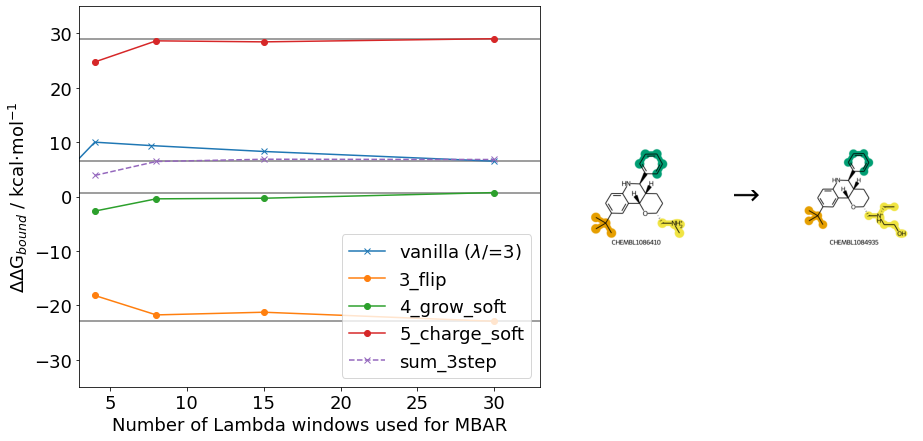

<Figure size 720x360 with 0 Axes>

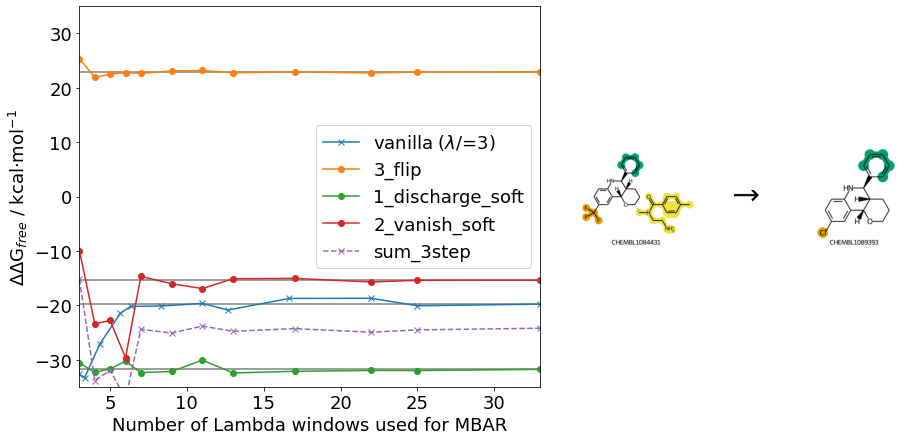

<Figure size 720x360 with 0 Axes>

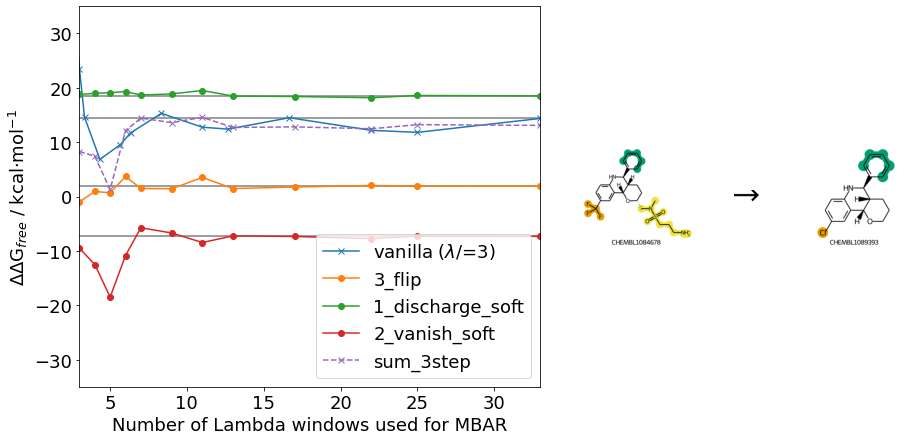

<Figure size 720x360 with 0 Axes>

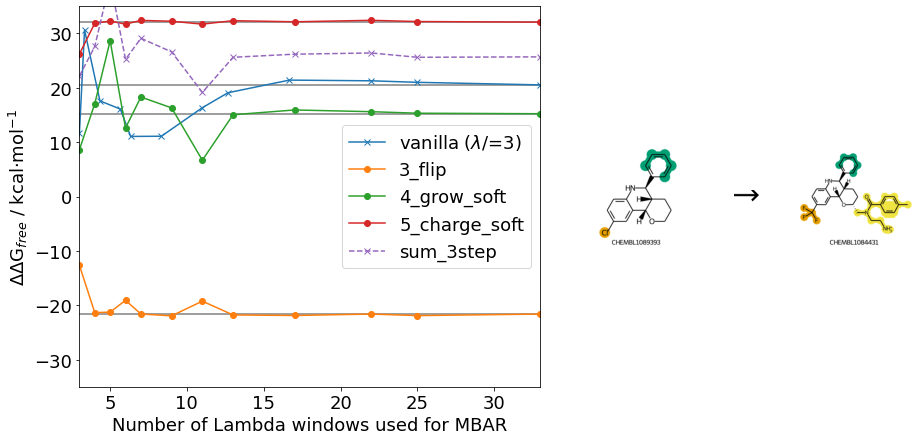

<Figure size 720x360 with 0 Axes>

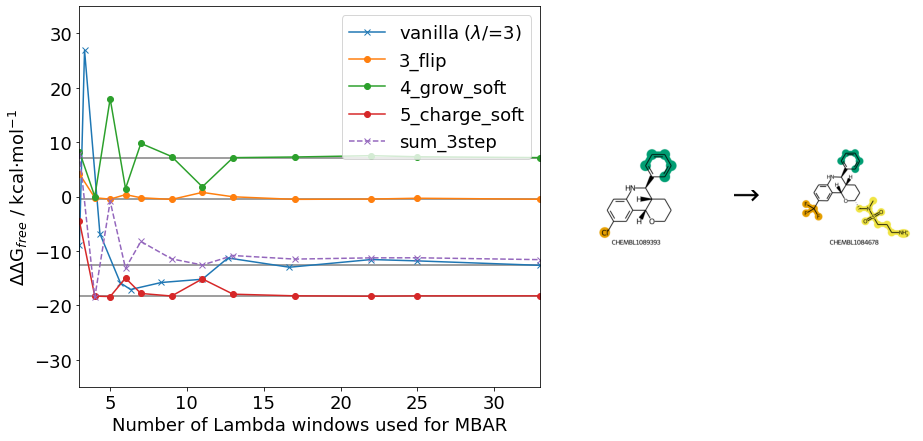

<Figure size 720x360 with 0 Axes>

In [273]:
phases = ["bound", "free", "free", "free", "free", "free"]

perts = ["CHEMBL1086410~CHEMBL1084935", "CHEMBL1084431~CHEMBL1089393", "CHEMBL1084678~CHEMBL1089393", "CHEMBL1089393~CHEMBL1084431", "CHEMBL1089393~CHEMBL1084678"]


pert_types = ["grow", "shrink", "shrink", "grow", "grow", "grow"]
plt.rcParams.update({'font.size': 18})

for pert, pert_type, phase in zip(perts, pert_types, phases):
    f, axes = plt.subplots(1,4, figsize=(15,7),  gridspec_kw={'width_ratios': [1.9, 0.5, 0.1, 0.5]})

    # plot lineplots on first axis:
    plot_steps_mbars(pert_type, phase, pert, axes[0])
    
    # plot the perturbation structures on the right:
    ligA = pert.split("~")[0]
    ligB = pert.split("~")[1]

    imgs_path = "../pre_setup/ligands/"

    imgA = mpimg.imread(imgs_path+ligA+".png")
    arrow = mpimg.imread(imgs_path+"arrow.png")
    imgB = mpimg.imread(imgs_path+ligB+".png")

    axes[1].imshow(imgA)
    axes[2].imshow(arrow)

    # turn off axes for perturbation:
    for ax in [axes[1], axes[2],axes[3]]:
        ax.axis('off')

    axes[3].imshow(imgB)
    
    

    plt.show()
    

## Running a triplicate of CHEMBL1084431~CHEMBL1089393 to check the sum/vanilla mismatch

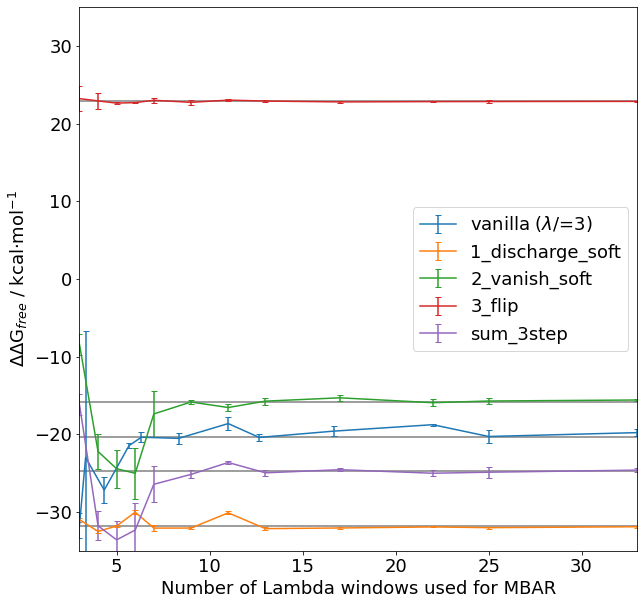

In [365]:

"""creates an axis with plots that show ddG versus lambda subselection for all steps."""

steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft"]

data_filler_dict = {
    "vanilla" : [],
    "1_discharge_soft" : [],
    "2_vanish_soft" : [],
    "3_flip" : [],
    "sum_3step" : []
}
for i in range(3):
    for step in steps:

        mbar_locs = "/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/"+\
        "lambda_subselector/extracted_mbars/ring_repeats/extracted_mbars/rep"+str(i+1)+"/"+step+\
        "/free/mbar_selections/mbar_selection_*/*.out"
 
        selection_mbar_files = glob.glob(mbar_locs)
        for mbar_file in selection_mbar_files:

            # get the free energy and num lambdas for this lambda selection:
            freenrg, num_lambdas = grabMBARFreenrg(mbar_file)
            

            # append to filler dict:
            data_filler_dict[step].append([float(freenrg), num_lambdas])

    # sort all values in this dict:
    for key, values in data_filler_dict.items():
        # sort the dict values:
        data_filler_dict[key].sort(key=lambda x: x[1])

    
# make the line that shows the sum of the 3step values per lambda config:
sum_values = np.zeros(np.array(data_filler_dict["3_flip"]).shape)
sum_counter = 0

for key, values in data_filler_dict.items():
    if not key == "vanilla":
        if values:
            sum_values += np.array(values)
            sum_counter += 1

# divide back the lambda numbers (they were also added together):
sum_values[:, 1] /= sum_counter

# add the sum_3step to the dict:
for pair in sum_values:
    data_filler_dict["sum_3step"].append([pair.tolist()[0], int(pair.tolist()[1])])

def return_arrays(step):
    # make arrays of x, y and z(std) for easy plotting:
    nested_input = data_filler_dict[step]

    binned_per_lam = np.array_split(nested_input, len(nested_input)/3)
    x = []
    y = []
    z = []
    for triplet in binned_per_lam:
        freenrg_mean = np.mean(triplet[:,0])
        freenrg_std = np.std(triplet[:,0])
        lambda_num = triplet[0][1]
        
        x.append(lambda_num)
        y.append(freenrg_mean)
        z.append(freenrg_std)
        
    return [x, y, z]
    

fig, ax = plt.subplots(figsize=(10,10))    
for step, values in data_filler_dict.items():

    x, y, std = return_arrays(step)
          
    # we want to squish down the vanilla line by 3 so it aligns with the multistep:
    if step == "vanilla":
        x = [val/3 for val in x]
        ax.errorbar(x, y, yerr=std, label=step+" ($\lambda$/=3)", ls=None, capsize=3)
    else:
        ax.errorbar(x, y, yerr=std, label=step, ls=None, capsize=3)

        
# format:    
for step in list(data_filler_dict.keys()):
    ax.axhline(data_filler_dict[step][-1][0], zorder=-100, color="grey")
ax.legend()
ax.set_xlim(3,33)
ax.set_ylim(-35,35)
ax.set_xlabel("Number of Lambda windows used for MBAR")
ax.set_ylabel("$\Delta\Delta$G$_{"+phase+"}$ / kcal$\cdot$mol$^{-1}$")

plt.legend()
plt.show()


implemented a fix in the pertfiles (bug in shared dihedrals):

In [377]:
def plot_steps_mbars(pert_type, phase, pert, ax):
    """creates an axis with plots that show ddG versus lambda subselection for all steps."""
    
    if pert_type == "grow":
        steps = ["vanilla", "3_flip", "4_grow_soft", "5_charge_soft"]
    elif pert_type == "shrink":
        steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft"]
    elif pert_type == "both":
        steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft", "4_grow_soft", "5_charge_soft"]

    data_filler_dict = {
        "vanilla" : [],
        "1_discharge_soft" : [],
        "2_vanish_soft" : [],
        "3_flip" : [],
        "4_grow_soft" : [],
        "5_charge_soft"  : []   
    }
    for step in steps:

        selection_mbar_files = glob.glob("/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/lambda_subselector/extracted_mbars/ring_fix/"+step+"/free/mbar_selections/mbar_selection_*/MBAR.out")
                                            
        for mbar_file in selection_mbar_files:

            # get the free energy and num lambdas for this lambda selection:
            freenrg, num_lambdas = grabMBARFreenrg(mbar_file)
    
            # append to filler dict:
            data_filler_dict[step].append([float(freenrg), num_lambdas])

    # sort all values in this dict:
    for key, values in data_filler_dict.items():
        # sort the dict values:
        data_filler_dict[key].sort(key=lambda x: x[1])

    # make the line that shows the sum of the 3step values per lambda config:
    sum_values = np.zeros(np.array(data_filler_dict["3_flip"]).shape)
    sum_counter = 0

    for key, values in data_filler_dict.items():
        if not key == "vanilla":
            if values:
                sum_values += np.array(values)
                sum_counter += 1

    # divide back the lambda numbers (they were also added together):
    sum_values[:, 1] /= sum_counter

    plt.figure(figsize=(10,5))
    for step in steps:
        freenrgs = [ vals[0] for vals in data_filler_dict[step] ]

        # we want to squish down the vanilla line by 3 so it aligns with the multistep:
        if step == "vanilla":
            lambdas = [ vals[1] for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step+" ($\lambda$/=3)", marker='x')
        else:
            lambdas = [ vals[1] for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step, marker='o')

    # now plot the sum line as well:
    ax.plot(sum_values[:,1], sum_values[:,0], label="sum_3step", marker='x', ls="--")


    # format:
    for step in steps:
        ax.axhline(data_filler_dict[step][-1][0], zorder=-100, color="grey")
    ax.legend()
    ax.set_xlim(3,90)
    ax.set_ylim(-35,35)
    ax.set_xlabel("Number of Lambda windows used for MBAR")
    ax.set_ylabel("$\Delta\Delta$G$_{"+phase+"}$ / kcal$\cdot$mol$^{-1}$")
    pass


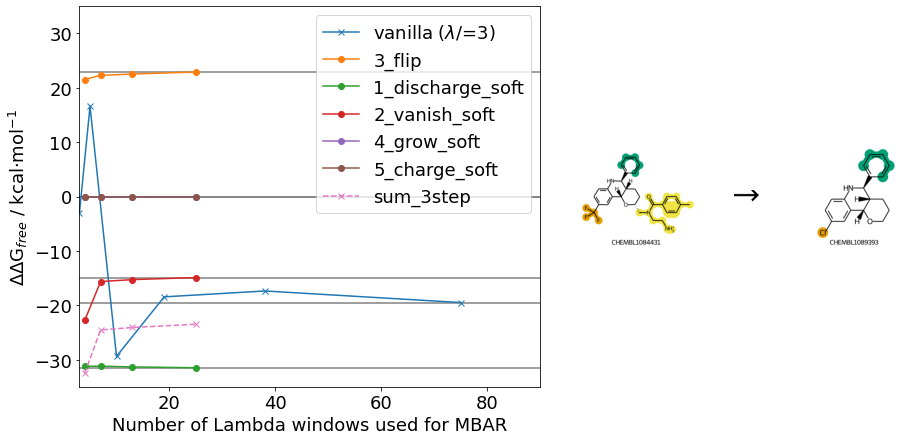

<Figure size 720x360 with 0 Axes>

In [378]:
phase = "free"

pert = "CHEMBL1084431~CHEMBL1089393"


pert_type = "both"
plt.rcParams.update({'font.size': 18})

f, axes = plt.subplots(1,4, figsize=(15,7),  gridspec_kw={'width_ratios': [1.9, 0.5, 0.1, 0.5]})

# plot lineplots on first axis:
plot_steps_mbars(pert_type, phase, pert, axes[0])

# plot the perturbation structures on the right:
ligA = pert.split("~")[0]
ligB = pert.split("~")[1]

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

axes[1].imshow(imgA)
axes[2].imshow(arrow)

# turn off axes for perturbation:
for ax in [axes[1], axes[2],axes[3]]:
    ax.axis('off')

axes[3].imshow(imgB)



plt.show()

In [379]:
def plot_steps_mbars(pert_type, phase, pert, ax):
    """creates an axis with plots that show ddG versus lambda subselection for all steps."""
    
    if pert_type == "grow":
        steps = ["vanilla", "3_flip", "4_grow_soft", "5_charge_soft"]
    elif pert_type == "shrink":
        steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft"]
    elif pert_type == "both":
        steps = ["vanilla", "3_flip", "1_discharge_soft", "2_vanish_soft", "4_grow_soft", "5_charge_soft"]

    data_filler_dict = {
        "vanilla" : [],
        "1_discharge_soft" : [],
        "2_vanish_soft" : [],
        "3_flip" : [],
        "4_grow_soft" : [],
        "5_charge_soft"  : []   
    }
    for step in steps:

        selection_mbar_files = glob.glob("/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/lambda_subselector/extracted_mbars/ring_fix2/"+step+"/free/mbar_selections/mbar_selection_*/MBAR.out")
                                            
        for mbar_file in selection_mbar_files:

            # get the free energy and num lambdas for this lambda selection:
            freenrg, num_lambdas = grabMBARFreenrg(mbar_file)
    
            # append to filler dict:
            data_filler_dict[step].append([float(freenrg), num_lambdas])

    # sort all values in this dict:
    for key, values in data_filler_dict.items():
        # sort the dict values:
        data_filler_dict[key].sort(key=lambda x: x[1])

    # make the line that shows the sum of the 3step values per lambda config:
    sum_values = np.zeros(np.array(data_filler_dict["3_flip"]).shape)
    sum_counter = 0

    for key, values in data_filler_dict.items():
        if not key == "vanilla":
            if values:
                sum_values += np.array(values)
                sum_counter += 1

    # divide back the lambda numbers (they were also added together):
    sum_values[:, 1] /= sum_counter

    plt.figure(figsize=(10,5))
    for step in steps:
        freenrgs = [ vals[0] for vals in data_filler_dict[step] ]

        # we want to squish down the vanilla line by 3 so it aligns with the multistep:
        if step == "vanilla":
            lambdas = [ vals[1] for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step+" ($\lambda$/=3)", marker='x')
        else:
            lambdas = [ vals[1] for vals in data_filler_dict[step] ]
            ax.plot(lambdas, freenrgs, label=step, marker='o')

    # now plot the sum line as well:
    ax.plot(sum_values[:,1], sum_values[:,0], label="sum_3step", marker='x', ls="--")


    # format:
    for step in steps:
        ax.axhline(data_filler_dict[step][-1][0], zorder=-100, color="grey")
    ax.legend()
    ax.set_xlim(3,90)
    ax.set_ylim(-35,35)
    ax.set_xlabel("Number of Lambda windows used for MBAR")
    ax.set_ylabel("$\Delta\Delta$G$_{"+phase+"}$ / kcal$\cdot$mol$^{-1}$")
    pass


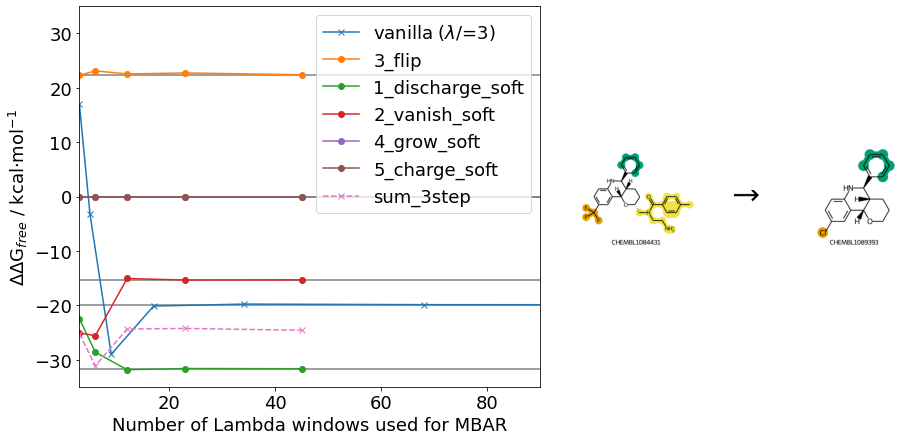

<Figure size 720x360 with 0 Axes>

In [380]:
phase = "free"

pert = "CHEMBL1084431~CHEMBL1089393"


pert_type = "both"
plt.rcParams.update({'font.size': 18})

f, axes = plt.subplots(1,4, figsize=(15,7),  gridspec_kw={'width_ratios': [1.9, 0.5, 0.1, 0.5]})

# plot lineplots on first axis:
plot_steps_mbars(pert_type, phase, pert, axes[0])

# plot the perturbation structures on the right:
ligA = pert.split("~")[0]
ligB = pert.split("~")[1]

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

axes[1].imshow(imgA)
axes[2].imshow(arrow)

# turn off axes for perturbation:
for ax in [axes[1], axes[2],axes[3]]:
    ax.axis('off')

axes[3].imshow(imgB)



plt.show()